# Targeted Training Notebook
A practical guide to the targeted training process. 

**Author:** Kalyan Dutia (kalyan.dutia@ibm.com)

Here we assume that you **already have your intents downloaded, in the `data/workspace_training` folder.** If you don't, you can manually download them or use the tool contained in the exploratory analysis notebook.

In [1]:
# external imports
import os
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
from itables import show
import logging
import time
import matplotlib.pyplot as plt

# internal imports
import config
from cli_tools.get_intent_intersections import intent_intersections
from cli_tools.diagnose_confusion import diagnose_confusion
from conversation_test.kfoldtest import kfoldtest

# config
sns.set_style("whitegrid")
sns.set_context("notebook")
pd.set_option('display.max_colwidth', -1)

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3.connectionpool").setLevel(logging.WARNING)


<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

## Load a skill
If you can't see your skill here, check the `data/workspace_training` folder.

In [3]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d)
        display_sample(d, 10)

def display_sample(d, samplesize):
    if samplesize != None:
        display(Markdown("**<span style='color:blue'>{}</span>** skill selected. Training data sample:".format(d.value)))
    training_file = training_files[d.index]

    train_df = pd.read_csv(os.path.join(config.training_dir, training_file), names=['utterance', 'intent'])
    if (len(train_df) > 0) & (samplesize != None):
        display(train_df.sample(samplesize))
    elif samplesize:
        display(Markdown("<span style='color:red'>No intent training data exists for this workspace</span>"))
    
    return train_df

training_files = [file for file in os.listdir(config.training_dir) if file.endswith('.csv')]
d = widgets.Dropdown(options=[item[0:len(item)-14] for item in training_files])
d.observe(onchange)

In [4]:
file_we_are_interested_in = d

In [5]:
display(file_we_are_interested_in)
train_df = display_sample(file_we_are_interested_in, 10)
intents = train_df['intent'].unique()

Dropdown(options=('Puppy', 'Phone Advisor', 'Puppy_Tra'), value='Puppy')

**<span style='color:blue'>Puppy</span>** skill selected. Training data sample:

,utterance,intent
115,does a pedigree need different immunisations to a mutt,DOG_VACCINATIONS
89,Is tinned dog food okay for puppies,DOG_FOOD
122,how can I check if my rescue staffy is up to date with it's injections,DOG_VACCINATIONS
96,how often should I feed my dog,DOG_FOOD
81,Can dogs eat people food,DOG_FOOD
16,I'd like to buy a wolfhound,PURCHASE_DOG
55,Was the litter sick for the puppy I want to get?,DOG_HEALTH
25,where is the puppy pricing,PURCHASE_DOG
112,can I combine my dogs next check up with some vaccinations,DOG_VACCINATIONS
84,What food do you sell,DOG_FOOD


We also need the details of the workspace and instance in Watson:

In [8]:
# first set workspace given selection above
train_df = display_sample(d, None)

# INSTANCE. Use one of apikey or username & password
apikey = ""
url = "https://api.eu-gb.assistant.watson.cloud.ibm.com"

# WORKSPACE 
workspace_id = "a4b7589d-9f17-4875-9272-d6e34f2768a2"
threshold = 0.4

# TEST PARAMS
nfolds = 2

## Run K-Fold test
In order to work out which intents to target, we first run a K-Fold test on our workspace.
You can also directly run one using the module in the `conversation_test` folder.

The kfold test returns:
- `results_kfold`: the classification per utterances
- `classification_report`: f1 score, accuracy, precision and recall per intent, as well as averages

If you haven't already set the number of folds or the threshold, have a look at the bottom of the above cell.

In [7]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

kfold = kfoldtest(apikey=apikey, url=url, n_folds=nfolds, threshold=threshold)
kfold.intent_df_from_df(train_df)
results_kfold, classification_report = kfold.full_run_kfold_from_df(train_df)

[2020-11-17 18:02:17,322] INFO (kfoldtest): You have space to perform the k-fold test
INFO:kfoldtest:You have space to perform the k-fold test
[2020-11-17 18:02:17,325] DEBUG (kfoldtest): fold num 1: train set: 90, test set: 46
DEBUG:kfoldtest:fold num 1: train set: 90, test set: 46
[2020-11-17 18:02:17,326] DEBUG (kfoldtest): fold num 2: train set: 91, test set: 45
DEBUG:kfoldtest:fold num 2: train set: 91, test set: 45
[2020-11-17 18:02:17,327] DEBUG (kfoldtest): fold num 3: train set: 91, test set: 45
DEBUG:kfoldtest:fold num 3: train set: 91, test set: 45
[2020-11-17 18:02:17,329] INFO (kfoldtest): Creating kfold workspaces..
INFO:kfoldtest:Creating kfold workspaces..
[2020-11-17 18:02:18,647] INFO (kfoldtest): Checking workspaces..
INFO:kfoldtest:Checking workspaces..
[2020-11-17 18:02:39,262] INFO (kfoldtest): Checking workspaces..
INFO:kfoldtest:Checking workspaces..
[2020-11-17 18:02:39,743] DEBUG (kfoldtest): Workspace 2 available
DEBUG:kfoldtest:Workspace 2 available
[2020-11

### View worst performing intents
We'll first choose a metric, then create a CSV showing the worst performing intents which can be used for annotation throughout this process.

In [22]:
display(Markdown("Now, we need to <span style='color:blue'>choose which metric to prioritise for this workspace.</span>" 

"\n \n If FPs and FNs are equally negative, then you may want to look at F1 score. More on this in **Section x** of the training at scale guide."

"\n \n**Preferred metric:**"))
        
d_m = widgets.Dropdown(options=['precision', 'recall', 'accuracy', 'F1'])
display(d_m)

Now, we need to <span style='color:blue'>choose which metric to prioritise for this workspace.</span>
 
 If FPs and FNs are equally negative, then you may want to look at F1 score. More on this in **Section x** of the training at scale guide.
 
**Preferred metric:**

Dropdown(options=('precision', 'recall', 'accuracy', 'F1'), value='precision')

In [23]:
cl_rep_export = classification_report.loc[intents, :].sort_values(d_m.value, ascending=True)
cl_rep_export = cl_rep_export.drop(columns='set size')

intent_sizes = train_df.groupby('intent').count()
cl_rep_export['train_size'] = intent_sizes

cl_rep_export['comment'] = ""
cl_rep_export['action'] = ""

timestr = time.strftime("%Y%m%d-%H%M")
filename = d.value + '_kfold_results_' + timestr + '.csv'
output_path = os.path.join(config.output_folder, filename)
cl_rep_export.to_csv(output_path)

display(Markdown("We can then view K-fold results sorted by this metric, with a column added to show the size of the training set, and a couple more for annotation."))
display(Markdown("These results have been exported to <span style='color:blue'>{}</span> for annotation throughout the targeted training process.".format(output_path)))
display(cl_rep_export)



We can then view K-fold results sorted by this metric, with a column added to show the size of the training set, and a couple more for annotation.

These results have been exported to <span style='color:blue'>C:\Users\ivanmivanov\Desktop\dummy_files\IntentTraining-main\results\Puppy_kfold_results_20201113-1801.csv</span> for annotation throughout the targeted training process.

confusion,threshold,accuracy,precision,recall,F1,train_size,comment,action
DOG_VACCINATIONS,0.4,0.785714,0.814815,0.956522,0.880000,NaN,,
PURCHASE_DOG,0.4,0.928571,0.857143,0.888889,0.872727,NaN,,
DOG_HEALTH,0.4,0.896552,0.888889,1.000000,0.941176,NaN,,
DOG_PARENTS_INFORMATION,0.4,0.791667,0.950000,1.000000,0.974359,NaN,,
DOG_FOOD,0.4,0.925926,0.960000,1.000000,0.979592,NaN,,


We can also view a plot of these.

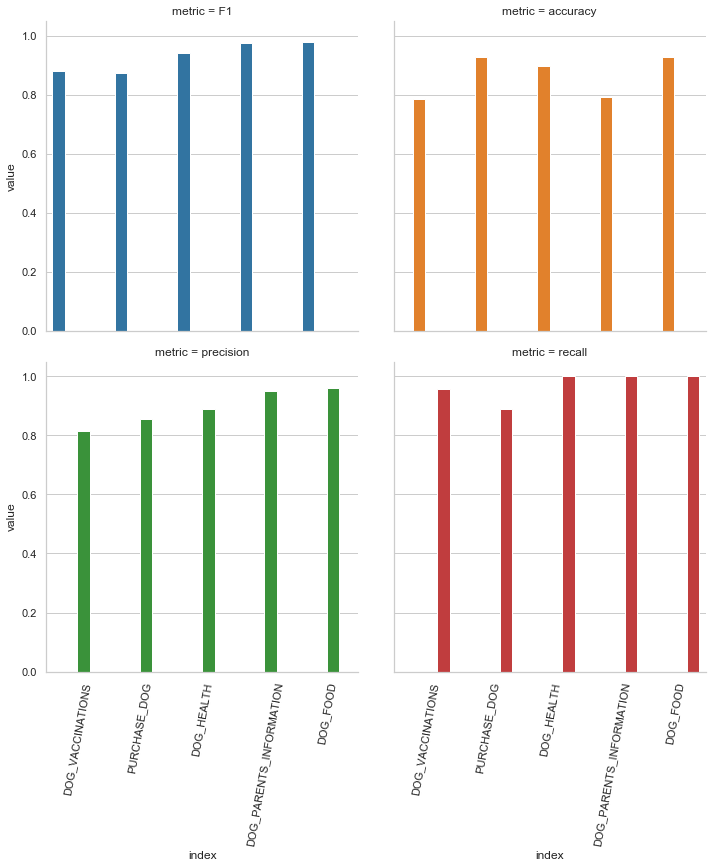

In [24]:
display(Markdown("We can also view a plot of these."))
melt_df = cl_rep_export.reset_index().melt(id_vars=['index'], value_vars=['F1', 'accuracy', 'precision', 'recall']).rename(columns={'confusion': 'metric'})
ax = sns.catplot(data=melt_df, col_wrap=2, x='index', y='value', col='metric', kind='bar', hue="metric")
[plt.setp(ax.get_xticklabels(), rotation=80) for ax in ax.axes.flat];

## Assess Root Cause
The next stage is to write some comments and actions for the training that is needed. To do this we'll use the tools in this section.

### More training?
A common sign that an intent needs more training is that it has **low recall**: it is commonly not matching intents with enough confidence to provide a response. To test for this we can plot recall against training set size for our intents. 

You should investigate any intents which fall on the bottom left hand size of this plot as candidates for getting more training.

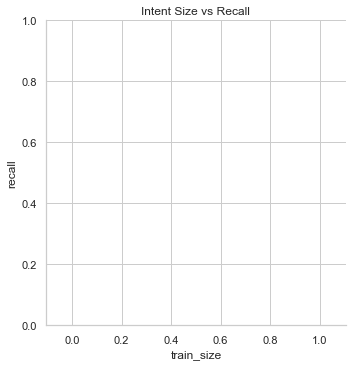

In [25]:
ax = sns.lmplot(data=cl_rep_export, x='train_size', y='recall', fit_reg=False)
ax.axes[0,0].set_title('Intent Size vs Recall')
ax.axes[0,0].set_ylim(0,1);

### Intent Overlaps
Here we'll use tools to find overlapping phrases between intents that may be causing confusion between them. 

Change the parameters in the next cell to choose the length of the ngrams being searched for, and whether to remove stopwords.

In [26]:
ngram_list = [4,5] 
stopwords = '_none' # stopwords_in can be none, nltk, or config

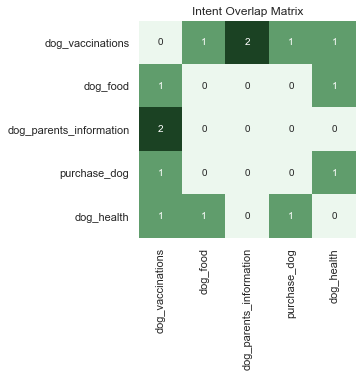

In [27]:
ii = intent_intersections(ngram_list, stopwords_in=stopwords, intent_col='intent')
ii.import_training_df(train_df)
intersection_df, intersection_size_df = ii.calculate_ngram_intersections()

intersection_size_df = intersection_size_df.fillna(0)
heatmap_colors = sns.cubehelix_palette(8, start=2, rot=0, dark=0.2, light=.95, reverse=False)
ax = sns.heatmap(intersection_size_df, annot=True, cmap=heatmap_colors, cbar=False, square=True)
ax.set_title('Intent Overlap Matrix');

Next, we can look into specific overlaps:

In [28]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d01)
        display(d02)
        display_intent_overlap(d01.value, d02.value)

def display_intent_overlap(intent1, intent2):
    if d01.value != d02.value:
        ngrams_per_intent_df, ngram_freq_df = ii.get_ngrams_per_intent()
        overlap_df = ii.get_intersection_freqs([intent1, intent2], ngram_freq_df)
        overlap_df = overlap_df.sort_values([intent1, intent2], ascending=False)
        display(overlap_df)
    else:
        display(Markdown("Intents chosen can't be the same"))

d01 = widgets.Dropdown(options=train_df['intent'].unique())
d02 = widgets.Dropdown(options=train_df['intent'].unique())

d01.observe(onchange)
d02.observe(onchange)

display(d01)
display(d02)
display_intent_overlap(d01.value, d02.value)

Dropdown(options=('dog_vaccinations', 'dog_food', 'dog_parents_information', 'purchase_dog', 'dog_health'), va…

Dropdown(options=('dog_vaccinations', 'dog_food', 'dog_parents_information', 'purchase_dog', 'dog_health'), va…

Intents chosen can't be the same

In [32]:
display(Markdown("You can use the table below to search through training utterances."))
show(train_df[['utterance', 'intent']])

You can use the table below to search through training utterances.

utterance,intent


### Diagnose Confusion
You can also find training utterances that may have caused misclassifications, by entering an utterance that has been misclassified.
Note that the list produced is only a guide which will find the most obvious samples (no stemming or lemmatisation), and in no way exhaustive.

You should also use the table above to search for different forms of words in the utterance.

In [22]:
# n_list = [1,2,3,4]
stopwords = None # None, 'nltk', or 'config'

######################
## DON'T EDIT BELOW ##
######################
def handle_submit(obj):
    clear_output()
    display(text_in)
    display( diagnose_confusion(obj.value, d.value, n_list, stopwords) )

text_in = widgets.Text()
display(text_in)
text_in.on_submit(handle_submit)

Text(value='')

## Training

The process of 'training' will fall into one of three categories: resolving clashes, cleaning training data, or getting more training data. 

See the last section of the Training at Scale guide for tips on how to improve your training data.